In [5]:
import numpy as np
#from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

import skglm
from skglm.datafits import Quadratic

from skglm.penalties import L1, L1_plus_L2, MCPenalty, L0_5, L2_1, SCAD


## Dataset

In [21]:
## CALIFORNIA HOUSING

california_housing = fetch_california_housing()

# The data is stored in the `data` attribute of the dataset object
X = california_housing.data

# The target values are stored in the `target` attribute
y = california_housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [129]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

### OVERFITT TOY DATASET

# generate toy data
X, y = make_regression(n_samples=100, n_features=1000, n_informative=10, random_state=0)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
### YEARSONG

from sklearn.datasets import fetch_openml


X, y = fetch_openml(data_id=44027, return_X_y=True)
X,y=X.to_numpy(), y.to_numpy()
X_train, X_test, y_train, y_test = X[:463715], X[463715:], y[:463715], y[:463715]

## Analyse

In [79]:
from skglm.penalties import L1, L1_plus_L2, MCPenalty, L0_5, L2_1, L2_3, SCAD

LAMBDA = 1
l1 = skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L1(alpha=LAMBDA))
l0_5=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L0_5(alpha=LAMBDA))
l2_3=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L2_3(alpha=LAMBDA))

GAMMA = 1
mc_pen=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=MCPenalty(alpha=LAMBDA, gamma=GAMMA))
scad= skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=SCAD(alpha=LAMBDA, gamma=GAMMA))

#models = {'Lasso': lasso, 'Ridge': ridge, 'ElasticNet': elastic_net}
models = {'l1': l1, "l0_5":l0_5, "l2_3":l2_3, "MCPenalty": mc_pen, "SCAD":scad }
for name, model in models.items():
    model.fit(X_train, y_train)

    mse_train=mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
    mse_test= mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

    sparsity = np.sum(abs(model.coef_ ) == 0)
    print(f"{name}: MSE_train = {mse_train:.2f},MSE_test = {mse_test:.2f}, Sparsity = {sparsity} / {len(model.coef_)}")

l1: MSE_train = 10.54,MSE_test = 20.65, Sparsity = 984 / 1000
l0_5: MSE_train = 31044.96,MSE_test = 27961.19, Sparsity = 991 / 1000
l2_3: MSE_train = 31044.27,MSE_test = 27813.65, Sparsity = 990 / 1000
MCPenalty: MSE_train = 0.00,MSE_test = 0.00, Sparsity = 990 / 1000
SCAD: MSE_train = 0.00,MSE_test = 0.00, Sparsity = 990 / 1000


In [128]:
import matplotlib.pyplot as plt

def plot(name, lambdas, mse_trains, mse_tests, sparsities):
    
# Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plot MSE
    color = 'tab:red'
    ax1.set_xlabel('Lambda')
    ax1.set_ylabel('MSE', color=color)
    ax1.plot(lambdas, mse_trains, label='Train MSE', color=color)
    ax1.plot(lambdas, mse_tests, label='Test MSE', color="orange")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    
    # Plot Sparsity
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Sparsity', color=color)  # we already handled the x-label with ax1
    ax2.plot(lambdas, sparsities, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_xscale('log')
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(f'{name} : MSE and Sparsity vs Lambda', weight='bold')
    plt.show()

## l0_5

In [82]:
def grid_search_l(lambdas, l):
    mse_trains = []
    mse_tests = []
    sparsities = []

    for LAMBDA in lambdas:

        if l=="l0_5":
            model=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L0_5(alpha=LAMBDA))
        elif l=="l1":
            model=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L1(alpha=LAMBDA))
        elif l=="l2_3":
            model=skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=L2_3(alpha=LAMBDA))
        model.fit(X_train, y_train)

        mse_train=mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
        mse_test= mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

        sparsity = np.sum(abs(model.coef_ )==0)
        #print(f"lambda = {LAMBDA}: MSE_train = {mse_train:.2f},MSE_test = {mse_test:.2f}, Sparsity = {sparsity} / {len(model.coef_)}")

        mse_trains.append(mse_train)
        mse_tests.append(mse_test)
        sparsities.append(sparsity)

    return mse_trains, mse_tests, sparsities

def grid_search_mcp(lambdas, gammas):
    mse_trains = []
    mse_tests = []
    sparsities = []

    for LAMBDA in lambdas:
        for GAMMA in gammas:
    #for GAMMA in [10**(k) for k in range(-2, 2)]:
            model = skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=MCPenalty(alpha=LAMBDA, gamma=GAMMA))
    
            model.fit(X_train, y_train)
    
            mse_train=mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
            mse_test= mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))
    
            sparsity = np.sum(abs(model.coef_ )==0)
            #print(f"lambda = {LAMBDA}, gamma = {GAMMA}: RMSE_train = {mse_train:.2f},RMSE_test = {mse_test:.2f}, Sparsity = {sparsity} / {len(model.coef_)}")
    
            mse_trains.append(mse_train)
            mse_tests.append(mse_test)
            sparsities.append(sparsity)

    return mse_trains, mse_tests, sparsities

def grid_search_scad(lambdas, gammas):
    mse_trains = []
    mse_tests = []
    sparsities = []

    for LAMBDA in lambdas:
        for GAMMA in gammas:
    #for GAMMA in [10**(k) for k in range(-2, 2)]:
            model = skglm.GeneralizedLinearEstimator(datafit=Quadratic(), penalty=SCAD(alpha=LAMBDA, gamma=GAMMA))
    
            model.fit(X_train, y_train)
    
            mse_train=mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
            mse_test= mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))
    
            sparsity = np.sum(abs(model.coef_ )==0)
            #print(f"lambda = {LAMBDA}, gamma = {GAMMA}: RMSE_train = {mse_train:.2f},RMSE_test = {mse_test:.2f}, Sparsity = {sparsity} / {len(model.coef_)}")
    
            mse_trains.append(mse_train)
            mse_tests.append(mse_test)
            sparsities.append(sparsity)

    return mse_trains, mse_tests, sparsities

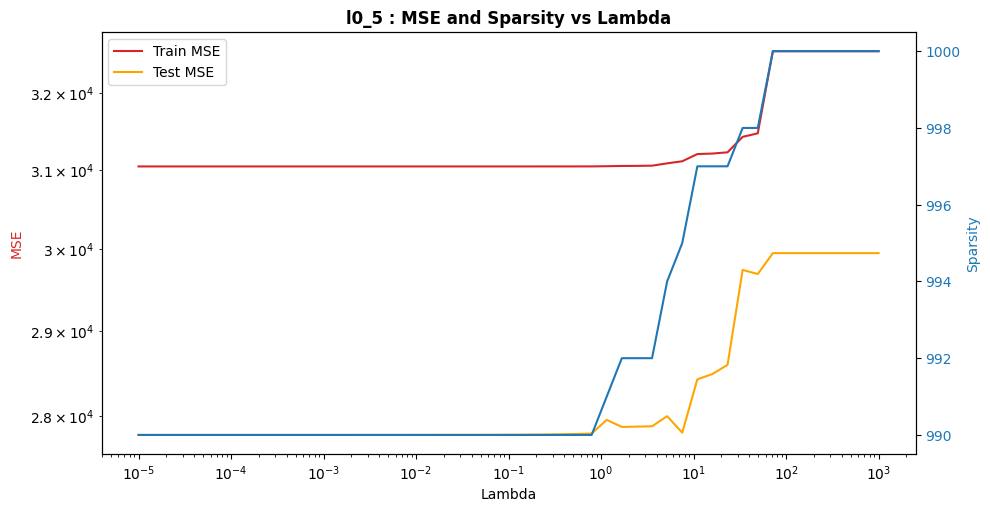

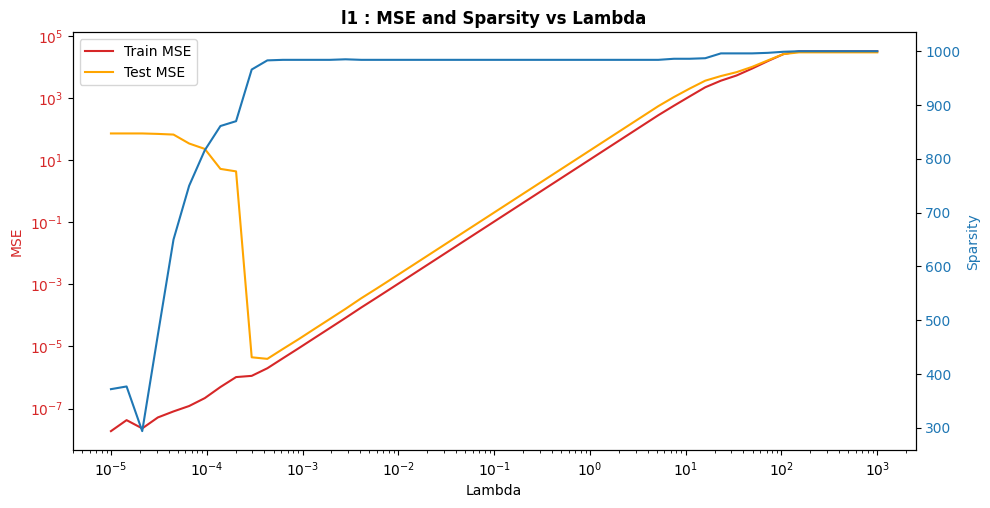

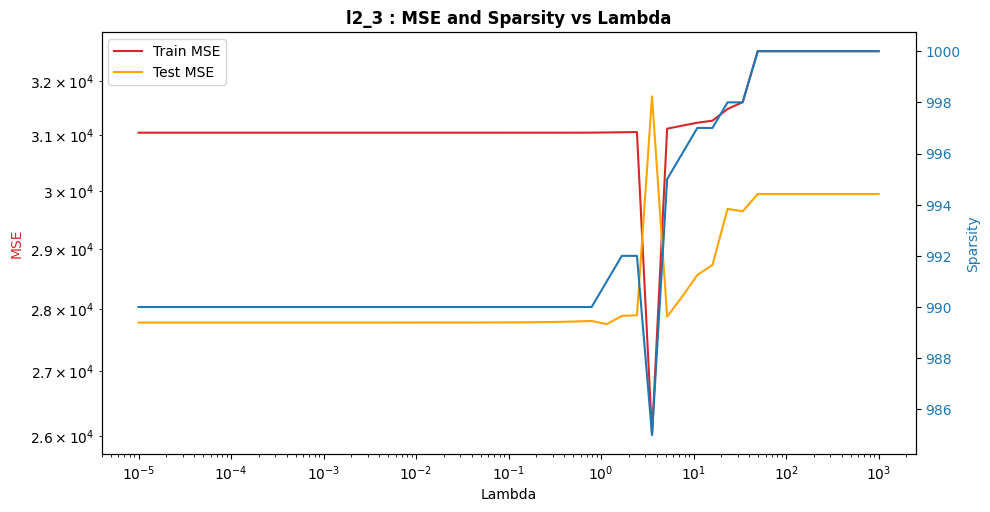

In [133]:
name="l0_5"

lambdas = np.logspace(-5, 3, 50)  # 100 values for lambda between 10^-2 and 10^2

for name in ["l0_5", "l1", "l2_3"]:

    mse_trains, mse_tests, sparsities = grid_search_l(lambdas=lambdas, l=name)
    
    plot(name=name, lambdas=lambdas, mse_tests=mse_tests, mse_trains=mse_trains, sparsities=sparsities)

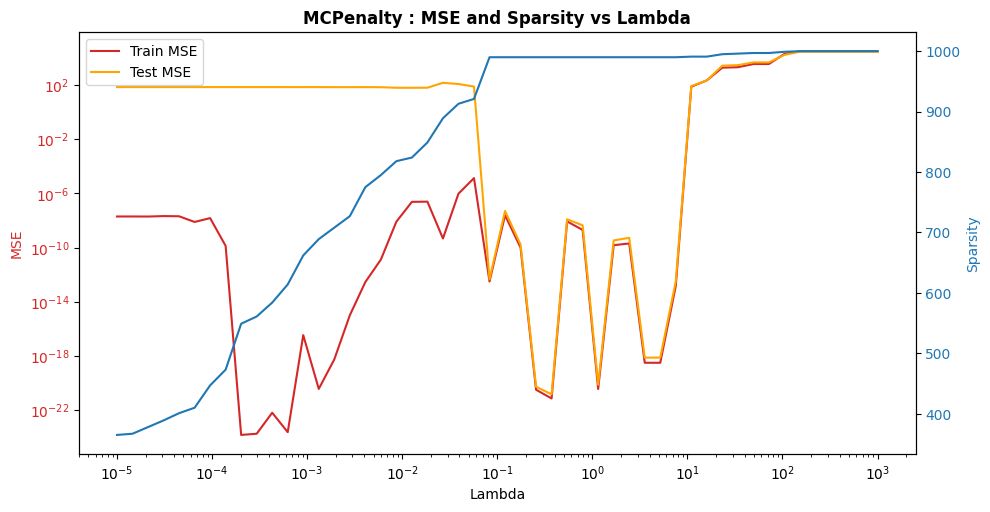

In [134]:
name="MCPenalty"

mse_trains = []
mse_tests = []
sparsities = []

lambdas = np.logspace(-5, 3, 50)  # 100 values for lambda between 10^-2 and 10^2
mse_trains, mse_tests, sparsities = grid_search_mcp(lambdas=lambdas, gammas=[1])

plot(name=name, lambdas=lambdas, mse_tests=mse_tests, mse_trains=mse_trains, sparsities=sparsities)


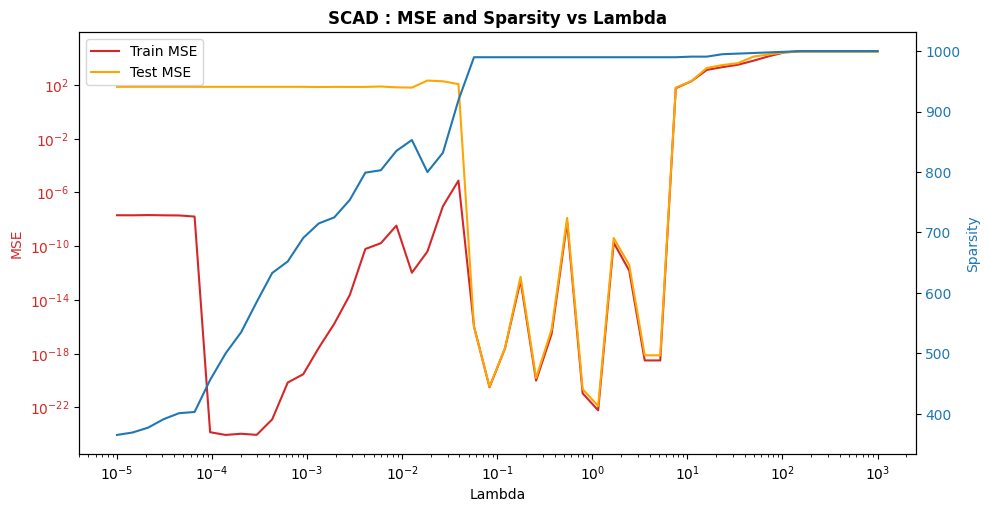

In [135]:
name="SCAD"

mse_trains = []
mse_tests = []
sparsities = []


lambdas = np.logspace(-5, 3, 50)  # 100 values for lambda between 10^-2 and 10^2
mse_trains, mse_tests, sparsities = grid_search_scad(lambdas=lambdas, gammas=[1])

plot(name=name, lambdas=lambdas, mse_tests=mse_tests, mse_trains=mse_trains, sparsities=sparsities)
